<a href="https://colab.research.google.com/github/LuBly/Knowledge_Distillation/blob/main/VGGnet19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy


Transform 정의, 데이터셋 준비.

In [9]:
print(torch.__version__)

##################### Transform, Data Set 준비


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

1.9.0+cu111
Files already downloaded and verified
Files already downloaded and verified


VGG19 모델링

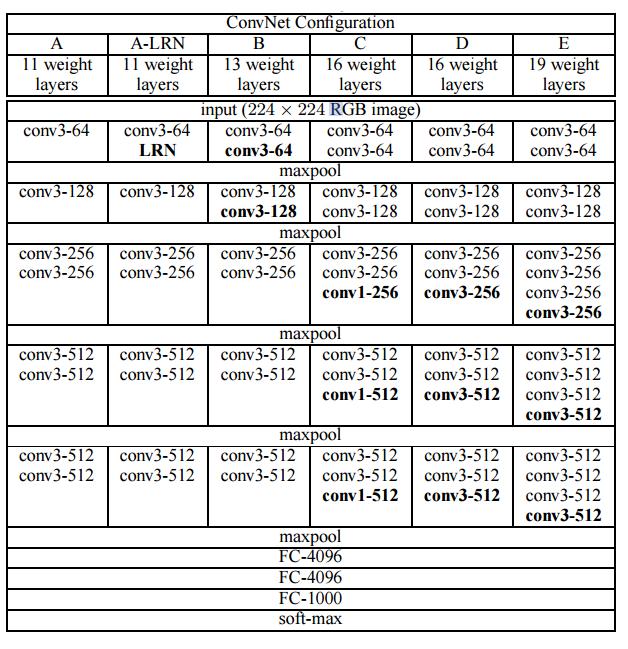

In [10]:
class VGG_B(nn.Module):
    def __init__(self, num_classes: int = 1000, init_weights: bool = True):
        super(VGG_B, self).__init__()
        self.convnet = nn.Sequential(
            # Input Channel (RGB: 3)
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224 -> 112
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112 -> 56
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56 -> 28

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 -> 14

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14 -> 7
        )

        self.fclayer = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
            # nn.Softmax(dim=1), # Loss인 Cross Entropy Loss 에서 softmax를 포함한다.
        )
    
    def forward(self, x:torch.Tensor):
        x = self.convnet(x)
        x = torch.flatten(x, 1)
        x = self.fclayer(x)
        return x

loss가 잘 잡히지 않아 weight 값에 문제가 있다고 판단하여, weight초기화 진행

In [11]:
def _initialize_weights(self): 
  for m in self.modules(): 
    if isinstance(m, nn.Conv2d): 
      nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') 
      if m.bias is not None: 
        nn.init.constant_(m.bias, 0) 
    
    elif isinstance(m, nn.BatchNorm2d): 
      nn.init.constant_(m.weight, 1) 
      nn.init.constant_(m.bias, 0) 
    
    elif isinstance(m, nn.Linear): 
      nn.init.normal_(m.weight, 0, 0.01) 
      nn.init.constant_(m.bias, 0)



모델 학습하기

Train

In [12]:
# utils

vgg19 = VGG_B(num_classes = 10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg19 = vgg19.to(device)

classes =  ('airplance', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')


criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(vgg19.parameters(),lr=0.00001)

start_time = time.time()
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # print(inputs.shape)  
        outputs= vgg19(inputs)

        # print(outputs.shape)
        # print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print(time.time()-start_time)
print('Finished Training')

[1,    50] loss: 2.303
[1,   100] loss: 2.303
[1,   150] loss: 2.303
[2,    50] loss: 2.303
[2,   100] loss: 2.303
[2,   150] loss: 2.303
[3,    50] loss: 2.303
[3,   100] loss: 2.302
[3,   150] loss: 2.303
[4,    50] loss: 2.303
[4,   100] loss: 2.303
[4,   150] loss: 2.303
[5,    50] loss: 2.303
[5,   100] loss: 2.303
[5,   150] loss: 2.303
[6,    50] loss: 2.303
[6,   100] loss: 2.303
[6,   150] loss: 2.303
[7,    50] loss: 2.303
[7,   100] loss: 2.302
[7,   150] loss: 2.303
[8,    50] loss: 2.303
[8,   100] loss: 2.254
[8,   150] loss: 2.128
[9,    50] loss: 2.031
[9,   100] loss: 2.018
[9,   150] loss: 1.952
[10,    50] loss: 1.932
[10,   100] loss: 1.919
[10,   150] loss: 1.856
2071.828437566757
Finished Training


loss가 크게 변하지않는다?

Validation

In [13]:
#
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = vgg19(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplance : 57 %
Accuracy of  bird : 35 %
Accuracy of   car : 48 %
Accuracy of   cat : 20 %
Accuracy of  deer : 27 %
Accuracy of   dog :  7 %
Accuracy of horse : 32 %
Accuracy of monkey :  6 %
Accuracy of  ship : 45 %
Accuracy of truck : 34 %


Reference
1. https://arxiv.org/abs/1409.1556
2. https://deep-learning-study.tistory.com/521
3. https://www.youtube.com/watch?v=ACmuBbuXn20&t=4s
4. https://wolfy.tistory.com/240